In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import seaborn as sns
# this to set the plot styles 
sns.set_context('paper', font_scale = 1.5, rc = {"lines.linewidth": 1.5})
sns.set_style('whitegrid', {'axes.grid': False, 'grid.linestyle': ''})

from Bio import Seq, SeqIO
from Bio.Seq import Seq
from Bio.Alphabet import generic_dna
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import FeatureLocation, CompoundLocation
import networkx as nx
from itertools import islice
import re

# import sklearn modules 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import matthews_corrcoef as mcc

label_encoder = LabelEncoder()
kfold = StratifiedKFold(n_splits = 3, shuffle = True)
# implementing a bag of words model where we weight each word by its document frequency 
tfidf_vec = TfidfVectorizer(ngram_range = (1,1), lowercase = True, analyzer = 'word', max_features = 4096) # cap the number of features

# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import torch
from fastai import *
from fastai.text import *
from fastai.text.interpret import *
from fastai.callbacks import *
# import look-ahead optimizer in lieu of Adam
from ranger import Ranger
optar = partial(Ranger)

import tensorflow as tf
tf.config.optimizer.set_jit(True)

n_trials = 5
ngram_size = 3
ngram_stride = 3
embedding_size = 400
test_frac = 0.10

# define functions to k-merize DNA and produce a 'sentence' of k-mer tokens 
def dna_kmerize(seq, ngram_size, ngram_stride):
    if ngram_size == 1:
        toks = list(seq) # for character level encoding of a dna sequence
    else:
        toks = [seq[i:i+ngram_size] for i in range(0, len(seq), ngram_stride) if len(seq[i:i+ngram_size]) == ngram_size]
    if len(toks[-1]) < ngram_size: # throw out tokens that don't match the length of the kmer (as opposed to a pad token, which serves the same purpose)
        toks = toks[:-1]
    return toks

# stitch the tokens together into a sentence 
def seq_sentence(seq, ngram_size, ngram_stride):
    
    toks = dna_kmerize(seq, ngram_size, ngram_stride)
    seq_sentence = ' '.join(toks)
    return seq_sentence

# define function for getting metrics 
def get_metrics(learn, ret = True):
    preds = learn.get_preds(ordered = True)
    p = torch.argmax(preds[0], dim=1)
    y = preds[1]

    tp = ((p + y) == 2).sum().item()
    tn = ((p + y) == 0).sum().item()
    fp = (p > y).sum().item()
    fn = (p < y).sum().item()
    
    acu = (tp+tn)/len(y)
    mcc = (float(tp)*tn - fp*fn) / np.sqrt((tp + fp)*(tp + fn)*(tn + fp)*(tn + fn))
    
    print(f'Accuracy: {(tp+tn)/len(y)}')
    print(f'False Positives: {fp/len(y)}')
    print(f'False Negatives: {fn/len(y)}')
    #print(f'Recall: {tp / (tp + fn)}')
    #print(f'Precision: {tp / (tp + fp)}')
    #print(f'Specificity: {tn / (tn + fp)}')
    print(f'MCC: {mcc}')

    if ret:
        return acu, mcc

# split into training and validation sets 
def split_gendata(df, frac):
    df = df.sample(frac = 1).reset_index(drop = True) # shuffle again 
    cut = int(len(df)*frac) + 1
    df_val = df.loc[:cut, :]
    df_trn = df.loc[cut:, :]
    return df_val, df_trn

def sent_scrambler2(seq, ngram_size, ngram_stride):
    x = seq_sentence(seq, ngram_size, ngram_stride)
    words = x.split() # break into tokens 
    random.shuffle(words)
    x_shuff_sent = ' '.join(words)
    shuff_toks = x_shuff_sent.replace(' ', '')
    return shuff_toks

def seq_scrambler(seq):
    chars = list(seq) # split into characters 
    random.shuffle(chars)
    shuff_seq = ''.join(chars) # join into a sequence
    return shuff_seq

def einsum_dist(u,v):
    z = u - v
    return np.sqrt(np.einsum('i,i->', z, z))

def emb_dist(emb_df1, emb_df2):
    l1 = emb_df1.shape[0]
    l2 = emb_df2.shape[0]
    dists = []
    if l1 == l2:
        for row in range(l1):
            a = emb_df1.iloc[row, :]
            b = emb_df2.iloc[row, :]
            dists.append(einsum_dist(u = a, v = b))
        euc_dist = pd.DataFrame()
        euc_dist['euclidean_dist'] = dists
        euc_dist['label'] = emb_df1.index.values.tolist()
    else:
        print('Embedding matrices are not the same shape!')
    return euc_dist

def pred_class(seq, learn_cf):
    cat_fwd, y_fwd, arr_fwd = learn_cf.predict(seq)
    p1f = to_np(arr_fwd)[1]
    yf = to_np(y_fwd)
    cls_fwd = cat_fwd.obj
    return cls_fwd

def seq_padder(x, maxlen):
    l = len(x)
    if l < maxlen:
        x += 'N'*(maxlen - l) # add padding to make sequences the same length
    else:
        x = x
    return x

# create a df of randomly generated toeholds from randomly generated switches 
import random

def rand_seq(length):
    return ''.join(random.choice('ATCG') for _ in range(length))

rand_switches = []
for i in range(8*10**5):
    temp = rand_seq(30)
    rand_switches.append(temp)

df_randLM = pd.DataFrame()
df_randLM['switch'] = rand_switches

# convert the switches into toehold sensors given the switch sequence 
# and the start_codon and the rbs site 
def turn_switch_to_toehold(switch, rbs = 'AACAGAGGAGA', start_codon = 'ATG'):
    stem1 = Seq(switch[24:30]).reverse_complement().__str__()
    stem2 = Seq(switch[12:21]).reverse_complement().__str__()
    toehold =  switch + rbs + stem1 + start_codon + stem2

    return toehold

df_randLM['min_toehold_sequence'] = df_randLM['switch'].apply(lambda x: turn_switch_to_toehold(x))
# we now have a dataframe of all possible toeholds
start_codon = 'ATG'
toeholds = df_randLM['min_toehold_sequence'].values.tolist()
# remove all toeholds where there are start codons before the intended one starting at position 47
no_start = [x for x in toeholds if x.index(start_codon) == 47]

# check for any stop codons that occur after the start and remove these from the pool 
## revised so that we only consider no in-frame stops 
def check_for_stop(toehold): 
    stop_codons = ['TAG', 'TAA', 'TGA']
    bad_locations = [47, 50, 53, 56]
    search = False
    for stop in stop_codons:
        for bad_loc in bad_locations:
            stop_index = toehold.find(stop, bad_loc, bad_loc + 3) # val, start search, end search
            search_test = stop_index == bad_loc
            search = search | search_test
    return search


no_stop = [x for x in no_start if not check_for_stop(x)]
df_randLM = pd.DataFrame()
df_randLM['min_toehold_sequence'] = no_stop

torch.cuda.set_device(2)

#
path = Path('workdir/excels')
path2 = Path('workdir/encoders')
pltpath = 'workdir/results/'

In [2]:
# load in the toehold dataset and preprocess for ML 
df = pd.read_csv(path/'newQC_toehold_data.csv', comment = '#')

# rename the columns 
rename_dict = {
    "Unnamed: 0" : "toehold_id",
    "onoff_value" : "delta_onoff",
    "onoff_qc" : "delta_qc_onoff",
    "switch_sequence" : "min_toehold_sequence"
}

# clean up df to get rid of NaN and low qc reads 
df = df.rename(columns = rename_dict)
df = df.dropna() # throw out nan's 
ngs_qc_onind = df['on_qc'] >= 1.1 # keep all the acceptable reads for the ON
ngs_qc_offind = df['off_qc'] >= 1.1 # keep all the acceptable reads for the OFF
df = df.loc[ngs_qc_onind & ngs_qc_offind, :]

# bin the toeholds by their ON/OFF ratio into quartlies for the classifier 
df['ON/OFF quartile'] = pd.qcut(df['delta_onoff'], 
                                      q = 4, 
                                      labels = ['Bottom', '25-50', '50-75', 'Top',
                                               ])

ind_top = df['ON/OFF quartile'] == 'Top' # find the top 25% of toeholds
ind_bottom = df['ON/OFF quartile'] != 'Top' # find the bottom 75% of toeholds
df_best_toeholds = df.loc[ind_top, :] # slice out the top 25%
df_bad_toeholds = df.loc[ind_bottom, :] # slice out the bottom 75%

df_best_toeholds['Toehold Rating'] = 'Good'
df_bad_toeholds['Toehold Rating'] = 'Bad'
df_classify = pd.concat([df_best_toeholds, df_bad_toeholds], axis = 0)
df_classify['scrambled_toehold'] = df_classify['min_toehold_sequence'].apply(lambda x: seq_scrambler(x))
df_classify['shufftok_toehold'] = df_classify['min_toehold_sequence'].apply(lambda x: sent_scrambler2(seq = x, 
                                                                                       ngram_size = ngram_size, 
                                                                                       ngram_stride = ngram_stride))
df_classify = df_classify.sample(frac = 1).reindex() 

# find all random sequences 
substring1 = 'random'
df_classify['indices'] = df_classify['sequence_id'].str.find(substring1)
ind = df_classify['indices'] >= 0
ind2 = df_classify['indices'] < 0

df_random = df_classify.loc[ind,:]
df_random['class'] = 'random'
df_random = df_random.drop('indices', axis = 1)

df_classify = df_classify.loc[ind2,:]
df_classify = df_classify.drop('indices', axis = 1)

# find all human_tf sequences 
substring2 = 'human'
df_classify['indices'] = df_classify['sequence_id'].str.find(substring2)
ind = df_classify['indices'] >= 0
ind2 = df_classify['indices'] < 0

df_human = df_classify.loc[ind,:]
df_human['class'] = 'human'
df_human = df_human.drop('indices', axis = 1)

df_classify = df_classify.loc[ind2,:]
df_classify = df_classify.drop('indices', axis = 1)

# the rest are all viral sequences 
df_viral = df_classify
df_viral['class'] = 'viral'

df_classify = pd.concat([df_random, df_human, df_viral], axis = 0)

df_LM = pd.concat([df_classify[['min_toehold_sequence']], df_randLM], axis = 0)
valid_df, train_df = split_gendata(df_LM, test_frac)
train_df['is_train'] = 1
valid_df['is_train'] = 0

import dna_ulmfit as dulm
from torch import *
# this class tokenizes with constant kmer and variable stride 

class GenomicConstantTokenizer2(BaseTokenizer):

    def __init__(self, lang = 'en', kmer = ngram_size, stride = ngram_stride):
        self.lang = lang
        self.kmer = kmer
        self.stride = stride

    def tokenizer(self, t):
        t = t.upper() # ensure all uppercase 
        if self.kmer == 1:
            toks = list(t) # trivial case when the kmer is of length 1 
        else:
            toks = [t[i:i+self.kmer] for i in range(0, len(t), self.stride)]   
        return toks # list of tokens 
    
    def add_special_cases(self, toks):
        pass
    
tokenizer = Tokenizer(tok_func = GenomicConstantTokenizer2, 
                      pre_rules = [], post_rules = [],
                      special_cases = ['xxpad'])


# forward language 
toehold_LMf = dulm.GenomicTextLMDataBunch.from_df(path = path, train_df = train_df, valid_df = valid_df,
                                                   tokenizer = tokenizer, text_cols = 'min_toehold_sequence', 
                                                  label_cols = 1, bs = 128, backwards = False, bptt = 60) # create a forward language model 
# reverse language
toehold_LMr = dulm.GenomicTextLMDataBunch.from_df(path = path, train_df = train_df, valid_df = valid_df,
                                                   tokenizer = tokenizer, text_cols = 'min_toehold_sequence', 
                                                  label_cols = 1, bs = 128, backwards = True, bptt = 60) # create a backwards language model
config_fwd = dict(emb_sz = embedding_size, 
              n_hid = 1552, 
              n_layers = 4, 
              pad_token = 0, 
              qrnn = True,
              bidir = False, 
              output_p = 0.15, 
              hidden_p = 0.20, 
              input_p = 0.30, 
              embed_p = 0.1, 
              weight_p = 0.25, 
              tie_weights = True, 
              out_bias = True)

config_rev = dict(emb_sz = embedding_size, 
              n_hid = 1552, 
              n_layers = 4, 
              pad_token = 0, 
              qrnn = True,
              bidir = False, 
              output_p = 0.15, 
              hidden_p = 0.20, 
              input_p = 0.30, 
              embed_p = 0.1, 
              weight_p = 0.25, 
              tie_weights = True, 
              out_bias = True)


classify_config = dict(
    emb_sz = embedding_size,
    n_hid = 1552, # multiply by two to account for bidirectionality if True
    n_layers = 4,
    pad_token = 0,
    qrnn = True,
    bidir = False,
    output_p = 0.5, # standard dropout applied to activations in the linear head
)

drop_mult = 1.0 # multiplier across all dropouts 
wd = 0.1 # strong l2 regularization

# 
learn_fwd = dulm.dnalanguage_model_learner(data = toehold_LMf, 
                                      arch = AWD_LSTM, 
                                      config = config_fwd, 
                                      drop_mult = drop_mult, 
                                      wd = wd)
learn_fwd = learn_fwd.to_fp16() 

learn_rev = dulm.dnalanguage_model_learner(data = toehold_LMr, 
                                      arch = AWD_LSTM, 
                                      config = config_rev, 
                                      drop_mult = drop_mult, 
                                      wd = wd)
learn_rev = learn_rev.to_fp16()

In [ ]:
# save the vocabs from the language models 
np.save(path2/'toehold_LMf_vocab.npy', toehold_LMf.vocab.itos)
np.save(path2/'toehold_LMr_vocab.npy', toehold_LMr.vocab.itos)

def FlatCosAnnealScheduler(learn, lr:float = 5e-3, tot_epochs:int = 1, moms:Floats = (0.8,0.7),
                          start_pct:float = 0.4, curve = 'cosine'):
    "Manage FCFit training as found in the ImageNette experiments"
    n = len(learn.data.train_dl)
    anneal_start = int(n * tot_epochs * start_pct)
    batch_finish = ((n * tot_epochs) - anneal_start)
    if curve=="cosine":        
        curve_type=annealing_cos
    elif curve=="linear":      
        curve_type=annealing_linear
    elif curve=="exponential": 
        curve_type=annealing_exp
    else: 
        raiseValueError(f"annealing type not supported {curve}")
        
    phase0 = TrainingPhase(anneal_start).schedule_hp('lr', lr).schedule_hp('mom', moms[0])
    phase1 = TrainingPhase(batch_finish).schedule_hp('lr', lr, anneal=curve_type).schedule_hp('mom', moms[1])
    
    phases = [phase0, phase1]
    
    return GeneralScheduler(learn, phases)

# train the forward model 
learn_fwd.unfreeze()
schedf = FlatCosAnnealScheduler(learn_fwd, lr = 5e-3, tot_epochs = 15, moms = (0.8, 0.7));
learn_fwd.callbacks.append(schedf)
learn_fwd.fit(15)
learn_fwd.save('toe_LMf')
learn_fwd.save_encoder('toe_LMf_enc')


In [ ]:
# train the reverse model 
learn_rev.unfreeze()
schedr = FlatCosAnnealScheduler(learn_rev, lr = 5e-3, tot_epochs = 15, moms = (0.8, 0.7));
learn_rev.callbacks.append(schedr)
learn_rev.fit(15)
learn_rev.save('toe_LMr')
learn_rev.save_encoder('toe_LMr_enc')

In [3]:
# load the respective vocabs
voc_fwd = np.load(path2/'toehold_LMf_vocab.npy')
voc_rev = np.load(path2/'toehold_LMr_vocab.npy')
fwd_model_vocab = dulm.GenomicVocab(voc_fwd)
rev_model_vocab = dulm.GenomicVocab(voc_rev)

# load the saved language models if pretrained
learn_fwd = learn_fwd.load('toe_LMf');
learn_rev = learn_rev.load('toe_LMr');

In [4]:
y_targets = df_classify['Toehold Rating']
X_samples = df_classify.drop('Toehold Rating', axis = 1)

scores = []
aucs = []
fracs = []
mccs = []
mccs_c1 = []
mccs_c2 = []
c1_scores = [] # for the control shuffled tokens
c2_scores = [] # for the control shuffled characters
tprs = []
aucs = []

# first prepare the dataset for testing
X_withheld, X_test, y_withheld, y_test = train_test_split(X_samples, 
                                                            y_targets, 
                                                            train_size = 1 - test_frac, 
                                                            shuffle = True, 
                                                            stratify = y_targets)
        
# now partition the remainder for testing and validation 
X_train, X_valid, y_train, y_valid = train_test_split(X_withheld, 
                                                    y_withheld, 
                                                    train_size = 1 - test_frac, 
                                                    shuffle = True, 
                                                    stratify = y_withheld)
            
df_train = pd.concat([X_train, y_train], axis = 1)
df_train['set'] = 'train'
        
df_valid = pd.concat([X_valid, y_valid], axis = 1)
df_valid['set'] = 'valid'
        
df_test = pd.concat([X_test, y_test], axis = 1)
df_test['set'] = 'test'
        
toehold_df = pd.concat([df_train, df_valid], axis = 0)
toehold_df = toehold_df.sample(frac = 1).reindex() # shuffle up
        
train_df = toehold_df[toehold_df.set == 'train']
valid_df = toehold_df[toehold_df.set == 'valid']
test_df = df_test # evaluate on the original test set 

        
# create a databunch for feeding into the NLP routine using the same tokenizer as the language model 
toehold_dbf = dulm.GenomicTextClasDataBunch.from_df(path = path, train_df = train_df, valid_df = valid_df,
                                                test_df = test_df, tokenizer = tokenizer, vocab = fwd_model_vocab,
                                                text_cols = 'min_toehold_sequence', label_cols = 'Toehold Rating',
                                                bs = 128, backwards = False)

toehold_dbr = dulm.GenomicTextClasDataBunch.from_df(path = path, train_df = train_df, valid_df = valid_df,
                                                test_df = test_df, tokenizer = tokenizer, vocab = rev_model_vocab,
                                                text_cols = 'min_toehold_sequence', label_cols = 'Toehold Rating',
                                                bs = 128, backwards = True)

In [5]:
learn_cf = dulm.dna_classifier_learner(data = toehold_dbf, 
                                               arch = AWD_LSTM, 
                                               config = classify_config, 
                                               drop_mult = drop_mult,
                                               clip = None, wd = 0.1, bptt = 60)
learn_cf = learn_cf.to_fp16()
learn_cf.load_encoder('/work/06658/pramesh/maverick2/excels/models/toe_LMf_enc')
learn_cf.fit_one_cycle(9, max_lr = 5e-2)
        
learn_cf.freeze_to(-2)
learn_cf.fit_one_cycle(5, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.95))
        
learn_cf.freeze_to(-3)
learn_cf.fit_one_cycle(5, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.95))
        
learn_cf.unfreeze()
learn_cf.fit_one_cycle(8, max_lr = 2.5e-3)
learn_cf = learn_cf.to_fp32()

epoch,train_loss,valid_loss,accuracy,time
0,0.540938,0.510565,0.743384,00:21
1,0.532572,0.503499,0.757344,00:20
2,0.541195,0.513239,0.750061,00:19
3,0.539309,0.508190,0.750182,00:19
4,0.532802,0.507479,0.750546,00:20
5,0.537244,0.502759,0.755159,00:20
6,0.529259,0.499232,0.754188,00:20
7,0.519181,0.492172,0.760257,00:19
8,0.518490,0.492742,0.758558,00:20


epoch,train_loss,valid_loss,accuracy,time
0,0.525612,0.488441,0.760500,00:22
1,0.513455,0.478230,0.762685,00:21
2,0.508622,0.464278,0.768390,00:21
3,0.494885,0.458713,0.770211,00:21
4,0.497058,0.456262,0.778223,00:21


epoch,train_loss,valid_loss,accuracy,time
0,0.497746,0.455621,0.777130,00:26
1,0.495340,0.452801,0.778587,00:26
2,0.493908,0.449888,0.780044,00:26
3,0.495915,0.449420,0.778587,00:26
4,0.484629,0.448465,0.779073,00:25


epoch,train_loss,valid_loss,accuracy,time
0,0.489950,0.446047,0.780529,00:40
1,0.476764,0.432648,0.791454,00:40
2,0.462907,0.420455,0.798131,00:40
3,0.444179,0.415656,0.796067,00:40
4,0.440368,0.411109,0.800923,00:40
5,0.440013,0.406005,0.803472,00:40
6,0.431101,0.404403,0.804321,00:40
7,0.436521,0.403796,0.806385,00:40


In [6]:
data_classify_testf = dulm.GenomicTextClasDataBunch.from_df(path = path, train_df = train_df, valid_df = test_df,
                                                tokenizer = tokenizer, vocab = fwd_model_vocab,
                                                text_cols = 'min_toehold_sequence', label_cols = 'Toehold Rating',
                                                bs = 128, backwards = False)
# assign this data to the trained learner 
learn_cf.data = data_classify_testf
# compute metrics 
preds, _, _ = learn_cf.get_preds(ordered = True, with_loss = True)
roc_aucf = roc_auc_score(test_df['Toehold Rating'], preds[:,1])
acuf, mccf = get_metrics(learn_cf)

Accuracy: 0.8074065982084335
False Positives: 0.06095695870657636
False Negatives: 0.13163644308499017
MCC: 0.4427750468950172


In [7]:
learn_cr = dulm.dna_classifier_learner(data = toehold_dbr, 
                                               arch = AWD_LSTM, 
                                               config = classify_config, 
                                               drop_mult = drop_mult,
                                               clip = None, wd = 0.1, bptt = 60)
learn_cr = learn_cr.to_fp16()
learn_cr.load_encoder('/work/06658/pramesh/maverick2/excels/models/toe_LMr_enc')
learn_cr.fit_one_cycle(9, max_lr = 5e-2)
        
learn_cr.freeze_to(-2)
learn_cr.fit_one_cycle(5, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.95))
        
learn_cr.freeze_to(-3)
learn_cr.fit_one_cycle(5, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.95))
        
learn_cr.unfreeze()
learn_cr.fit_one_cycle(8, max_lr = 2.5e-3)
learn_cr = learn_cr.to_fp32()

epoch,train_loss,valid_loss,accuracy,time
0,0.543371,0.508432,0.753581,00:19
1,0.539420,0.507732,0.751396,00:19
2,0.531948,0.517134,0.750425,00:19
3,0.540809,0.511315,0.750910,00:19
4,0.537529,0.511636,0.749939,00:19
5,0.534697,0.508537,0.749939,00:19
6,0.530211,0.504736,0.757101,00:19
7,0.529455,0.501102,0.750910,00:19
8,0.525520,0.500298,0.754795,00:19


epoch,train_loss,valid_loss,accuracy,time
0,0.515231,0.492062,0.753702,00:21
1,0.511719,0.475109,0.765477,00:21
2,0.504151,0.470964,0.768633,00:21
3,0.509874,0.466742,0.767541,00:21
4,0.497352,0.464682,0.770818,00:21


epoch,train_loss,valid_loss,accuracy,time
0,0.502894,0.464998,0.769361,00:25
1,0.507935,0.463812,0.767177,00:25
2,0.503869,0.463002,0.771789,00:26
3,0.500745,0.462623,0.769119,00:26
4,0.509200,0.461712,0.773731,00:26


epoch,train_loss,valid_loss,accuracy,time
0,0.506209,0.460930,0.771546,00:40
1,0.486535,0.450970,0.774703,00:40
2,0.467367,0.431684,0.786356,00:40
3,0.457795,0.415312,0.802622,00:40
4,0.443451,0.407498,0.805414,00:40
5,0.437680,0.403463,0.807720,00:40
6,0.433013,0.404162,0.807113,00:40
7,0.433613,0.403722,0.807720,00:40


In [8]:
# define the test set data bunch
data_classify_testr = dulm.GenomicTextClasDataBunch.from_df(path = path, train_df = train_df, valid_df = test_df,
                                                tokenizer = tokenizer, vocab = rev_model_vocab,
                                                text_cols = 'min_toehold_sequence', label_cols = 'Toehold Rating',
                                                bs = 128, backwards = True)
# assign this data to the trained learner 
learn_cr.data = data_classify_testr
# compute metrics 
preds, _, _ = learn_cr.get_preds(ordered = True, with_loss = True)
roc_aucr = roc_auc_score(test_df['Toehold Rating'], preds[:,1])
acur, mccr = get_metrics(learn_cr)

Accuracy: 0.8025999563032554
False Positives: 0.09547738693467336
False Negatives: 0.10192265676207123
MCC: 0.46918643474336374


In [9]:
learn_cf.save('fwd_cf_learner')
learn_cr.save('rev_cr_learner')

In [37]:
learn_cf.save_encoder('fwd_cf_encoder')
learn_cr.save_encoder('rev_cf_encoder')

In [10]:
# load Alex Green's data and fine-tune 
df_green = pd.read_csv(path/'Green2014_clean.csv')
df_green = df_green.drop('Unnamed: 0', axis = 1)
df_green.head()

,Toehold ID,Toehold sequence,Switch region,Trigger,Avg ONOFF,sdev ONOFF,Toehold Rating
0,68,AATGTATGTAATAGTTCGTCGAGGTGTCCAAGCAGAGGAGATGGAC...,AATGTATGTAATAGTTCGTCGAGGTGTCCA,TGGACACCTCGACGAACTATTACATACATT,24.8,2.2,Bad
1,110,ATGATAATGTAGAGGTGCGGAGTGATTGTAAACAGAGGAGATACAA...,ATGATAATGTAGAGGTGCGGAGTGATTGTA,TACAATCACTCCGCACCTCTACATTATCAT,9.7,1.1,Bad
2,100,CGAAGTATTGTAAGGTGTAGTGTGCGTTGAGACAGAGGAGATCAAC...,CGAAGTATTGTAAGGTGTAGTGTGCGTTGA,TCAACGCACACTACACCTTACAATACTTCG,13.6,1.5,Bad
3,116,TAAGTAAATGAAAGTGTATGTATGTTGCTGGACAGAGGAGACAGCA...,TAAGTAAATGAAAGTGTATGTATGTTGCTG,CAGCAACATACATACACTTTCATTTACTTA,8.7,1.1,Bad
4,117,TCAATAAGGCGGAGTTCGTCGAGGTGCCTGAGCAGAGGAGACAGGC...,TCAATAAGGCGGAGTTCGTCGAGGTGCCTG,CAGGCACCTCGACGAACTCCGCCTTATTGA,8.5,1.4,Bad


In [17]:
y_targets = df_green['Toehold Rating']
X_samples = df_green.drop('Toehold Rating', axis = 1)

# first prepare the dataset for testing
X_withheld, X_test, y_withheld, y_test = train_test_split(X_samples, 
                                                            y_targets, 
                                                            train_size = 1 - test_frac, 
                                                            shuffle = True, 
                                                            stratify = y_targets)
        
# now partition the remainder for testing and validation 
X_train, X_valid, y_train, y_valid = train_test_split(X_withheld, 
                                                    y_withheld, 
                                                    train_size = 1 - test_frac, 
                                                    shuffle = True, 
                                                    stratify = y_withheld)
            
df_train = pd.concat([X_train, y_train], axis = 1)
df_train['set'] = 'train'
        
df_valid = pd.concat([X_valid, y_valid], axis = 1)
df_valid['set'] = 'valid'
        
df_test = pd.concat([X_test, y_test], axis = 1)
df_test['set'] = 'test'
            
toehold_df = pd.concat([df_train, df_valid], axis = 0)
toehold_df = toehold_df.sample(frac = 1).reindex() # shuffle up
        
train_df2 = toehold_df[toehold_df.set == 'train']
valid_df2 = toehold_df[toehold_df.set == 'valid']
test_df2 = df_test # evaluate on the original test set 

        
# create a databunch for feeding into the NLP routine using the same tokenizer as the language model 
toehold_dbf2 = dulm.GenomicTextClasDataBunch.from_df(path = path, train_df = train_df2, valid_df = valid_df2,
                                                test_df = test_df2, tokenizer = tokenizer, vocab = fwd_model_vocab,
                                                text_cols = 'Toehold sequence', label_cols = 'Toehold Rating',
                                                bs = 64, backwards = False)

toehold_dbr2 = dulm.GenomicTextClasDataBunch.from_df(path = path, train_df = train_df2, valid_df = valid_df2,
                                                test_df = test_df2, tokenizer = tokenizer, vocab = rev_model_vocab,
                                                text_cols = 'Toehold sequence', label_cols = 'Toehold Rating',
                                                bs = 64, backwards = True)

learn_cf2 = dulm.dna_classifier_learner(data = toehold_dbf2, 
                                               arch = AWD_LSTM, 
                                               config = classify_config, 
                                               drop_mult = drop_mult,
                                               clip = None, wd = 0.1, bptt = 60)
learn_cf2 = learn_cf2.load('fwd_cf_learner');
learn_cf2 = learn_cf2.to_fp16()
learn_cf2.fit_one_cycle(9, max_lr = 5e-2)
        
learn_cf2.freeze_to(-2)
learn_cf2.fit_one_cycle(5, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.95))
        
learn_cf2.freeze_to(-3)
learn_cf2.fit_one_cycle(5, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.95))
        
learn_cf2.unfreeze()
learn_cf2.fit_one_cycle(8, max_lr = 2.5e-3)
learn_cf2 = learn_cf2.to_fp32()

data_classify_testf = dulm.GenomicTextClasDataBunch.from_df(path = path, train_df = train_df2, valid_df = test_df2,
                                                tokenizer = tokenizer, vocab = fwd_model_vocab,
                                                text_cols = 'Toehold sequence', label_cols = 'Toehold Rating',
                                                bs = 64, backwards = False)
# assign this data to the trained learner 
learn_cf2.data = data_classify_testf
# compute metrics 
preds, _, _ = learn_cf2.get_preds(ordered = True, with_loss = True)
roc_aucf = roc_auc_score(test_df2['Toehold Rating'], preds[:,1])
acuf, mccf = get_metrics(learn_cf2)

epoch,train_loss,valid_loss,accuracy,time
0,0.570631,0.466180,0.750000,00:00
1,0.567445,0.465661,0.812500,00:00
2,0.546005,0.470751,0.812500,00:00
3,0.546277,0.518231,0.812500,00:00
4,0.531400,0.586048,0.750000,00:00
5,0.515334,0.542000,0.875000,00:00
6,0.502932,0.585596,0.812500,00:00
7,0.489884,0.610373,0.812500,00:00
8,0.483825,0.566496,0.875000,00:00


epoch,train_loss,valid_loss,accuracy,time
0,0.455781,0.568280,0.812500,00:00
1,0.434476,0.571319,0.875000,00:00
2,0.453702,0.569396,0.875000,00:00
3,0.458841,0.571365,0.875000,00:00
4,0.458142,0.571800,0.875000,00:00


epoch,train_loss,valid_loss,accuracy,time
0,0.523120,0.572004,0.875000,00:00
1,0.503661,0.579393,0.875000,00:00
2,0.476960,0.576192,0.875000,00:00
3,0.465497,0.573934,0.875000,00:00
4,0.458911,0.577615,0.875000,00:00


epoch,train_loss,valid_loss,accuracy,time
0,0.565033,0.583228,0.812500,00:00
1,0.502313,0.583615,0.812500,00:00
2,0.492206,0.581973,0.875000,00:00
3,0.488791,0.585906,0.812500,00:00
4,0.481985,0.591080,0.812500,00:00
5,0.466454,0.580716,0.812500,00:00
6,0.471590,0.585381,0.812500,00:00
7,0.469285,0.578159,0.875000,00:00


Accuracy: 0.7058823529411765
False Positives: 0.11764705882352941
False Negatives: 0.17647058823529413
MCC: 0.10699012312772822


In [76]:
learn_cr2 = dulm.dna_classifier_learner(data = toehold_dbr2, 
                                               arch = AWD_LSTM, 
                                               config = classify_config, 
                                               drop_mult = drop_mult,
                                               clip = None, wd = 0.1, bptt = 60)
learn_cr2 = learn_cr2.load('rev_cr_learner');
learn_cr2 = learn_cr2.to_fp16()
learn_cr2.fit_one_cycle(9, max_lr = 5e-2)
        
learn_cr2.freeze_to(-2)
learn_cr2.fit_one_cycle(5, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.95))
        
learn_cr2.freeze_to(-3)
learn_cr2.fit_one_cycle(5, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.95))
        
learn_cr2.unfreeze()
learn_cr2.fit_one_cycle(12, max_lr = 1e-3)
learn_cr2 = learn_cr2.to_fp32()
data_classify_testr = dulm.GenomicTextClasDataBunch.from_df(path = path, train_df = train_df2, valid_df = test_df2,
                                                tokenizer = tokenizer, vocab = fwd_model_vocab,
                                                text_cols = 'Toehold sequence', label_cols = 'Toehold Rating',
                                                bs = 64, backwards = True)
# assign this data to the trained learner 
learn_cr2.data = data_classify_testr
# compute metrics 
preds, _, _ = learn_cr2.get_preds(ordered = True, with_loss = True)
roc_aucr = roc_auc_score(test_df2['Toehold Rating'], preds[:,1])
acur, mccr = get_metrics(learn_cr2)

epoch,train_loss,valid_loss,accuracy,time
0,0.551694,0.490387,0.750000,00:00
1,0.512338,0.495080,0.750000,00:00
2,0.501934,0.496494,0.750000,00:00
3,0.513974,0.512908,0.750000,00:00
4,0.517426,0.543457,0.750000,00:00
5,0.510670,0.570457,0.750000,00:00
6,0.501018,0.554714,0.750000,00:00
7,0.495570,0.567223,0.750000,00:00
8,0.489234,0.571253,0.750000,00:00


epoch,train_loss,valid_loss,accuracy,time
0,0.404361,0.582665,0.750000,00:00
1,0.410025,0.586648,0.687500,00:00
2,0.417860,0.589665,0.687500,00:00
3,0.425862,0.594081,0.687500,00:00
4,0.429730,0.594016,0.687500,00:00


epoch,train_loss,valid_loss,accuracy,time
0,0.441611,0.594408,0.687500,00:00
1,0.445087,0.594015,0.687500,00:00
2,0.432031,0.595217,0.687500,00:00
3,0.426270,0.595641,0.687500,00:00
4,0.421245,0.592511,0.687500,00:00


epoch,train_loss,valid_loss,accuracy,time
0,0.446466,0.591404,0.687500,00:00
1,0.409067,0.589489,0.750000,00:00
2,0.431736,0.590474,0.750000,00:00
3,0.417800,0.592727,0.687500,00:00
4,0.424024,0.596379,0.687500,00:00
5,0.433550,0.596544,0.750000,00:00
6,0.439993,0.595206,0.750000,00:00
7,0.435848,0.595596,0.750000,00:00
8,0.434877,0.597846,0.687500,00:00
9,0.436876,0.596407,0.750000,00:00


Accuracy: 0.6470588235294118
False Positives: 0.17647058823529413
False Negatives: 0.17647058823529413
MCC: 0.019230769230769232


In [64]:
def predict_prob(seq, learn_cf, learn_cr):
    cat_fwd, y_fwd, arr_fwd = learn_cf.predict(seq)
    cat_rev, y_rev, arr_rev = learn_cr.predict(seq)
    
    avg_prob = (arr_fwd + arr_rev)/2 # average the forward and backwards probabilities 
    p1 = to_np(avg_prob)[1] # probability of being 'good'
    return p1

def get_toeholdcls(cls_prob):
    if cls_prob > 0.75:
        rating = 'Good'
    else:
        rating = 'Bad'
    return rating

In [22]:
df_green['Prob good'] = df_green['Toehold sequence'].apply(lambda x: predict_prob(x, learn_cf2, learn_cr2))
df_green['Prob bad'] = 1 - df_green['Prob good']
df_green['Predicted rating'] = df_green['Prob good'].apply(lambda x: get_toeholdcls(x))

In [23]:
mcc(df_green['Toehold Rating'], df_green['Predicted rating'])

0.5303214634075973

In [36]:
learn_cf2.save('Green2014_fCF_Aug');
learn_cf2.save_encoder('Green2014_fCF_Aug_enc');

learn_cr2.save('Green2014_rCF_Aug');
learn_cr2.save_encoder('Green2014_rCF_Aug_enc');

In [77]:
# load Keith's data and evaluate pre-trained model
df_pardee = pd.read_excel(path/'Pardee2016_clean.xlsx')
df_pardee['sensor_dna_seq'] = df_pardee['Sensor sequence'].apply(lambda x: Seq(x).back_transcribe().__str__())
df_pardee['min_toehold_sequence'] = df_pardee['sensor_dna_seq'].apply(lambda x: x[18:77])
df_pardee['Prob good'] = df_pardee['min_toehold_sequence'].apply(lambda x: predict_prob(x, learn_cf2, learn_cr2))
df_pardee['Prob bad'] = 1 - df_pardee['Prob good']
df_pardee = df_pardee.sort_values(by = 'Rank')
df_pardee.head()

,Sensor Name,Sensor sequence,Rank,sensor_dna_seq,min_toehold_sequence,Prob good,Prob bad
7,8A,CUGGGAUCAAGUACAUGUAGUGCGCCACGAGCAAAAGUUAUAGUUA...,1,CTGGGATCAAGTACATGTAGTGCGCCACGAGCAAAAGTTATAGTTA...,AGTGCGCCACGAGCAAAAGTTATAGTTATGAACAGAGGAGACATAA...,0.620196,0.379804
6,7A,CUUCCACUGCAGUCUUCCACUCUUUUUCCUCUUCAAGUUAUAGUUA...,2,CTTCCACTGCAGTCTTCCACTCTTTTTCCTCTTCAAGTTATAGTTA...,ACTCTTTTTCCTCTTCAAGTTATAGTTATGAACAGAGGAGACATAA...,0.552606,0.447394
21,22A,AUUCCUCAAACCGAAUUUCAAGCUCUUCACUGUGCCGUUAUAGUUA...,3,ATTCCTCAAACCGAATTTCAAGCTCTTCACTGTGCCGTTATAGTTA...,CAAGCTCTTCACTGTGCCGTTATAGTTATGAACAGAGGAGACATAA...,0.796171,0.203829
11,12A,CCCACUCUUGAUGUUUUGUUUUCUGGAACUCUGUCUGUUAUAGUUA...,4,CCCACTCTTGATGTTTTGTTTTCTGGAACTCTGTCTGTTATAGTTA...,TTTTCTGGAACTCTGTCTGTTATAGTTATGAACAGAGGAGACATAA...,0.738265,0.261735
3,4A,GCUCCCCUUCUACUGAUCUCCACAUGAUGUUUUCCAGUUAUAGUUA...,5,GCTCCCCTTCTACTGATCTCCACATGATGTTTTCCAGTTATAGTTA...,TCCACATGATGTTTTCCAGTTATAGTTATGAACAGAGGAGACATAA...,0.512226,0.487774


Text(0, 0.5, 'Probability predicted in top 25%')

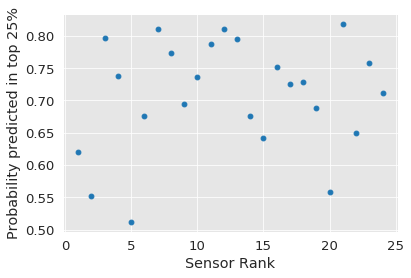

In [79]:
plt.plot(df_pardee['Rank'], df_pardee['Prob good'], 'o')
plt.xlabel('Sensor Rank')
plt.ylabel('Probability predicted in top 25%')